# **3. Data Preparation**

In this section I'll create methods to preprocess the training data available in `artifacts/train.csv` (at root, after running data_ingestion.py).

Based on the `2. Exploratory Data Analysis`, I have to do the following transfomations in the data:

1. **Tokenize text**

2. **Calculate reading ease score**

3. **Calculate lexical diversity**

4. **Remove stopwords**

5. **Remove irrelevant information (can be anything that has letters)**

7. **Fix typos**

8. **Remove nouns**

9. **Texts to vectors**


**Obs:**
* Before any text manipulation, the text need to be tokenize. That's why has `1.`;

* Before generating the text vector representation, typos must be fix. That's why has `7.`;

* I need a way to tranform the texts into vectors. And the way I'll handle it is with word2vec. That's why has `9.`;

## **Importing libraries**

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot

# text manipulation
import spacy
from spacy.tokens import Doc

# text typos detection
from symspellpy import SymSpell, Verbosity
import importlib.resources

# text statistics
import textstat

# scaling
from sklearn.preprocessing import MinMaxScaler

## **Setting up libraries**

In [3]:
# setting up spacy and disabling unused pipeline components
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner', 'lemmatizer', 'textcat', 'custom'])

In [4]:
# setting up SymSpell to typo detection
sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)

with importlib.resources.open_text('symspellpy', 'frequency_dictionary_en_82_765.txt') as file:
    dictionary_path = file.name
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

## **Loading training dataset**

In [5]:
data = pd.read_csv('../artifacts/train.csv')

In [6]:
# show first rows
data.head()

,text,generated
0,"The ""Face on mars"" is just a natural landform....",0
1,Imagine a life without cars. All those paved r...,0
2,"The temperature in Venus is over 800 degress, ...",0
3,Cars are one of the main causes of air polluti...,0
4,"]\n\nDear Senator [Senator's Last Name],\n\nI ...",1


## **Data Transformation**

I'll make all the required tranformation into an unique function even to obtain better performance.

In [10]:
def prepare_model_data(data):
    '''
    Helper function to prepare data to the ML model. 
    This function applies:
        * text tokenization
        * stopwords removing
        * irrelevant information removing
        * nouns removing
        * typos fixing
        * word2vec with spacy
        
    Also, this function calculate:
        * lexical diversity score
        * reading ease score

    Parameters
    ---
    * data: text data to prepare the data
    
    Returns
    ---
    * a numpy array with the columns: 300 size vector (representing the text), lexical_deversity_score and reading_ease_score

    '''

    # tranfrom texts in spacy docs (wich applies tokenization)
    docs = [doc for doc in nlp.pipe(data)]

    text_vectors = []
    reading_ease_scores = []
    lexical_diversity_scores = []

    def calculate_reading_ease_score(text: str) -> int:
        '''
        Helper function to calculate reading ease score.
        '''
        try:
            return textstat.flesch_reading_ease(text)
        except ZeroDivisionError:
            return 0
        
    def calculate_lexical_diversity_score(doc: Doc) -> float:
        '''
        Helper function to calculate lexical diversity from the given spacy doc.
        '''

        # get words count
        total_words_count = len(doc)
        unique_words_count = len(set(token.text.lower() for token in doc))

        if total_words_count == 0:
            return 0.0
        else:
            return unique_words_count / total_words_count

    for doc in docs:

        # reading ease score
        reading_ease_scores.append(calculate_reading_ease_score(doc.text))

        # lexical diversity score
        lexical_diversity_scores.append(calculate_lexical_diversity_score(doc))

        words = []
        spaces = []
        for token in doc:
            if token.is_stop or not re.match('[a-zA-Z]', token.text): # ignore stopwords and irrelevant information
                continue

            if token.pos_ in ['NOUN', 'PROPN']: # ignore nouns
                continue

            word = token.text.lower()

            # check if it has vector representaion
            if not token.has_vector:
                # lookup for typo
                suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1)

                # check if has any suggestion
                if not suggestions:
                    continue

                # fix typo to the closest suggestion
                word = suggestions[0].term
                    
            words.append(word)
            spaces.append(token.whitespace_)

        # create and add text vector to list
        clean_doc = Doc(vocab=nlp.vocab, words=words, spaces=spaces)
        text_vectors.append(clean_doc.vector)

    # return numpy array
    return np.column_stack([text_vectors, lexical_diversity_scores, reading_ease_scores])

In [11]:
# prepare the data
prepared_data = prepare_model_data(data.text)

In [12]:
print('Prepared data shape:', prepared_data.shape)

Prepared data shape: (23298, 302)


### **Applying Data Scaling**

My input data has the following structure:

* the first 300 data are related to the wor2vec representation of the text;

* then lexical_diversity_scores;

* and finally reading_ease_scores.

My plan to apply scaling here is the following:

* for the text representation part, I'll use MinMaxScaler, because I'm just interested in cosine similarity (that way size doesn't matters);

* make a prob plot for the other 2 variables to see if them follows a normal distribution, then, if they follow, I'll use StandardScaler, else I'll use MinMaxScaler.

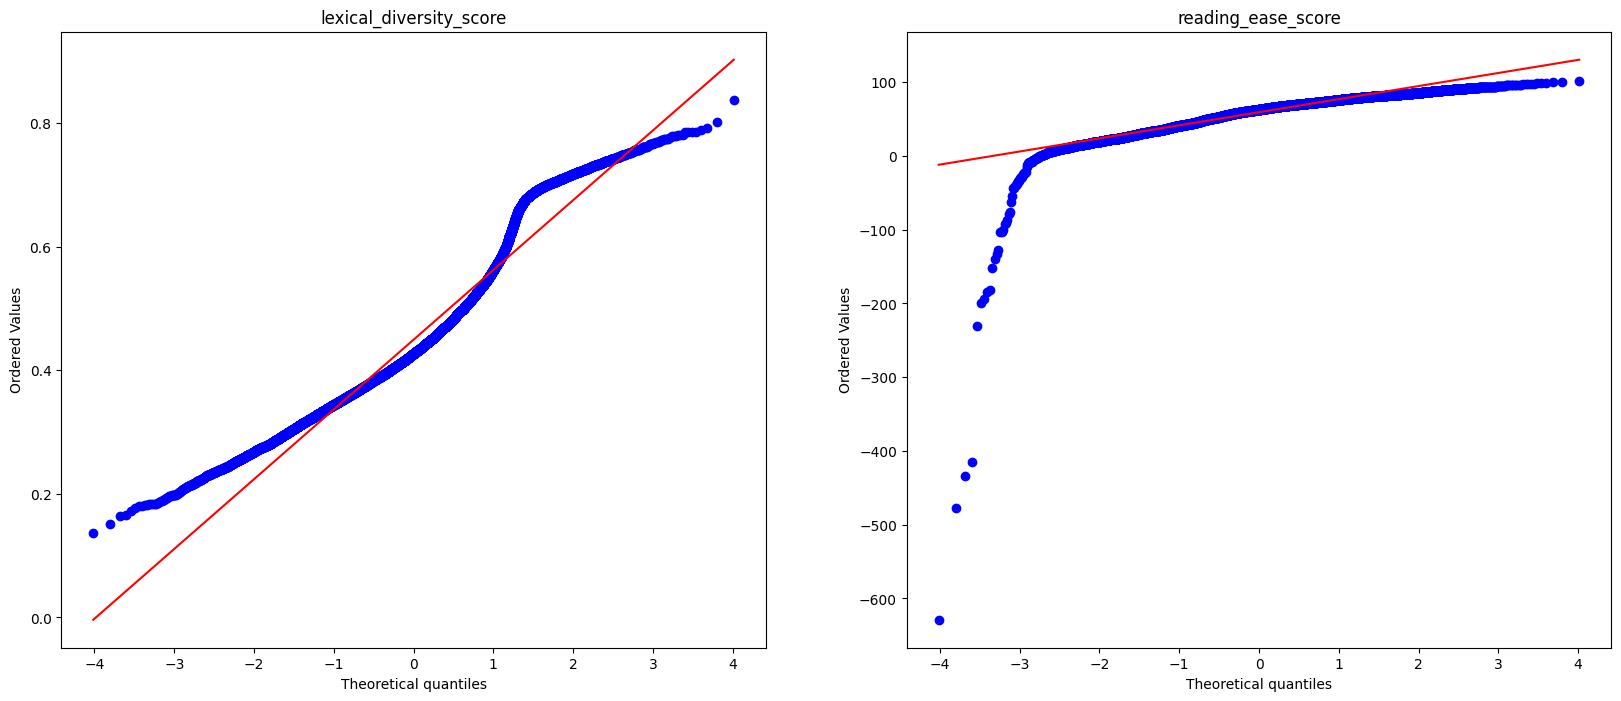

In [13]:
# create plot
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# plot probplot
probplot(prepared_data[:, 300], dist='norm', plot=ax0)
probplot(prepared_data[:, 301], dist='norm', plot=ax1)

# config plot
ax0.set_title('lexical_diversity_score')
ax1.set_title('reading_ease_score')

plt.show()

**Observations:**


* reading_ease_score: almost fit entirely well on the red line except by the start, dued to it, it has no normal distribution;

* lexical_diversity_score: doesn't fit the red line very well, it means that it doesn't have a normal distribution.

Because of this I'll use MinMaxScaler in the entire data.

In [14]:
prepared_data_scaled = prepared_data

# apply min max scaler
min_max_scaler = MinMaxScaler()
prepared_data_scaled = min_max_scaler.fit_transform(prepared_data_scaled)

In [15]:
# show result
prepared_data_scaled

array([[0.35093919, 0.23493821, 0.67018138, ..., 0.43550202, 0.5814953 ,
        0.96044471],
       [0.46927688, 0.33745541, 0.42420932, ..., 0.49967561, 0.41867192,
        0.95871955],
       [0.59129749, 0.35329789, 0.53893817, ..., 0.25683212, 0.44180491,
        0.96711256],
       ...,
       [0.3108346 , 0.30845074, 0.48958142, ..., 0.42142914, 0.33730815,
        0.94297411],
       [0.30828473, 0.20954177, 0.54399575, ..., 0.43863488, 0.76488189,
        0.91146953],
       [0.0463097 , 0.27436381, 0.49330025, ..., 0.47226999, 0.37806657,
        0.94630119]])

In [16]:
# show result shape
prepared_data_scaled.shape

(23298, 302)